## Reading the Data

In [180]:
import pandas as pd
import numpy as np
import math

column_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "class"]
train_data = pd.read_csv("train.txt", sep=",", header=None, names=column_names)
test_data = pd.read_csv("test.txt", sep=",", header=None, names=column_names[:-1])

## Preprocessing the data

In [181]:
# Compute mean of elements
def mean(elements):
    return float(sum(elements)) / float(len(elements))

# Standard deviation mean of elements
def standard_deviation(elements):
    m = mean(elements)
    var = sum([math.pow(e - m, 2) for e in elements]) / float(len(elements) - 1)
    return math.sqrt(var)
    
def z_score_normalization(data):
    for c in data.columns:
        data[c] = (data[c] - data[c].mean()) / data[c].std(ddof=0)
    return pd.DataFrame(data)

def cleaning(train_data, test_data):
    drop_column = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
    train_data = train_data.drop(columns = drop_column)
    test_data = test_data.drop(columns = drop_column)
    train_data["label"] = train_data["class"].apply(lambda x: -1 if x == " <=50K" else 1)
    train_data = train_data.drop(columns = "class")
    return train_data, test_data

train_data, X_test = cleaning(train_data, test_data)
X_train, y_train = np.split(train_data, [-1], axis=1)
X_train = z_score_normalization(X_train)
train_data = pd.concat([X_train, y_train], axis=1)
X_test = z_score_normalization(X_test)


## SVM 

In [196]:
import matplotlib.pyplot as plt

def plot_accuracy(plt_accuracy):
    for key in plt_accuracy:
        plt.plot([x*30 for x in range(len(plt_accuracy[key]))], plt_accuracy[key], label="Accuracy for lambda = " + str(key), alpha=0.7)
    plt.ylim(0, 1)
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per 30 step")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

def plot_magnitude(plt_a_magnitude, plt_b_magnitude):
    i = 0
    for key in plt_a_magnitude:
        plt.plot([x*30 for x in range(len(plt_a_magnitude[key]))], plt_a_magnitude[key], label="Magnitude of a for lambda = " + str(key), alpha=0.5)
    for key in plt_b_magnitude:
        plt.plot([x*30 for x in range(len(plt_b_magnitude[key]))], plt_b_magnitude[key], label="Magnitude of b for lambda = " + str(key), alpha=0.5)
    plt.xlabel("Steps")
    plt.ylabel("Magnitude")
    plt.title("Magnitude of a and b per 30 step")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

class SVM:
    def __init__(self, v_len):
        self.a = pd.Series(np.random.uniform(size=v_len), index=["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"])             
        self.b = np.random.uniform()
        self.l = 1e-3
        
    # Perform Stochastic Gradient Descent
    def fit(self, X_train, y_train, eta):
        a_n, b_n = self.a, self.b
        for i in range(30): # 30
            k = np.random.choice(range(len(y_train)))
            x_k, y_k = X_train.iloc[k], y_train.iloc[k]
            if (float(y_k) * (np.dot(a_n, x_k) + b_n)).item() >= 1:
                a_n = a_n - eta * self.l * a_n
                b_n = float(b_n)
            else:
                a_n = a_n - eta * (self.l * a_n - float(y_k) * x_k)
                b_n = float(b_n + eta * y_k)
        self.a = a_n
        self.b = float(b_n)
    
    def predict(self, x):
        if (np.dot(self.a, x) + self.b).item() >= 0:
            return 1
        else:
            return -1
        
    # + reshuflle + without replacement 
    def train_val_split(self, data, size):
        train_data, val_data = np.split(data.sample(frac=1, replace=False), [size])
        X_train, y_train = np.split(train_data, [-1], axis=1)
        X_val, y_val = np.split(val_data, [-1], axis=1)
        y_train = np.squeeze(y_train) # for n x 1 vector
        y_val = np.squeeze(y_val) # for n x 1 vector
        return X_train, y_train, X_val, y_val

    def compute_accuracy(self, X_val, y_val, l):
        accuracy = 0
        for i, x in X_val.iterrows():
            if self.predict(x) == y_val[i]:
                accuracy += 1
        accuracy /= float(len(X_val))
        return accuracy

    def cross_validation(self, train_data):
        max_accuracy_lambda = 0
        best_lambda = 0
        magnitude_a_plt = {}
        magnitude_b_plt = {}
        accuracy_plt = {}
        for l in [1e-3, 1e-2, 1e-1, 1]: # find best lambda hyperparameter
            plt_accuracy = []
            plt_a_magnitude = []
            plt_b_magnitude = []
            self.l = l
            self.a = pd.Series(np.random.uniform(size=6), 
                               index=["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"])
            self.b = np.random.uniform()
            X_train_lamdba, y_train_lamdba, X_val_lamdba, y_val_lamdba = self.train_val_split(train_data, 
                                                                                              int(.9*len(train_data)))
            n_season = 200 
            for season in range(n_season):
                eta = 2 / float(season + 8) #  a =2 b = 8 a = 0.79
                train_val_eta = pd.concat([X_train_lamdba, y_train_lamdba], axis=1)
                remaining_steps = 300
                while remaining_steps >= 30:
                    season_size = 300 
                    X_train_eta, y_train_eta, X_val_eta, y_val_eta = self.train_val_split(train_val_eta.sample(n=season_size), 
                                                                                          season_size-50)
                    self.fit(X_train_eta, y_train_eta, eta) 
                    plt_accuracy.append(self.compute_accuracy(X_val_eta, y_val_eta, l))
                    plt_a_magnitude.append(np.sqrt(np.square(self.a).sum()))
                    plt_b_magnitude.append(abs(self.b))
                    remaining_steps -= 30
            magnitude_a_plt[l] = plt_a_magnitude
            magnitude_b_plt[l] = plt_b_magnitude
            accuracy_plt[l] = plt_accuracy
            accuracy_lambda = self.compute_accuracy(X_val_lamdba, y_val_lamdba, l)
            if accuracy_lambda > max_accuracy_lambda:
                    max_accuracy_lambda = accuracy_lambda
                    best_lambda = l
        plot_accuracy(accuracy_plt)
        plot_magnitude(magnitude_a_plt, magnitude_b_plt)
        self.l = best_lambda
        print "Max accuracy is " + str(max_accuracy_lambda)
        print "Best lamdba is " + str(best_lambda)
    

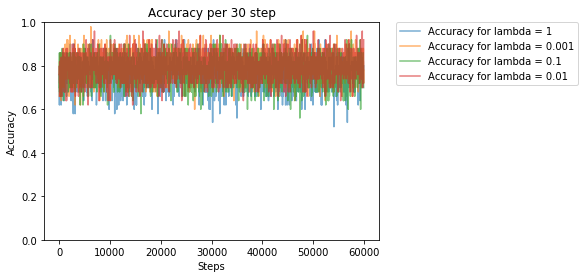

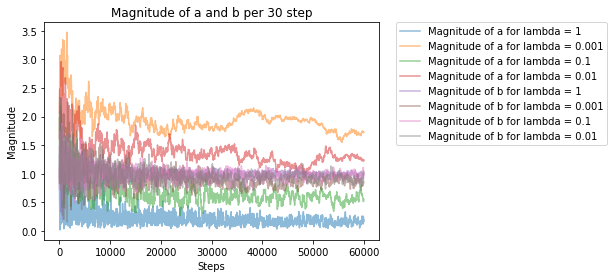

Max accuracy is 0.807552320291
Best lamdba is 0.001


In [197]:
%matplotlib inline

x_len = 6
svm = SVM(x_len)
svm.cross_validation(train_data)

In [198]:
def output_for_autograder(svm, X_test):
    with open("submission.txt", "w") as test_file:
        for i, x in X_test.iterrows():
            if svm.predict(x) == -1:
                test_file.write("<=50K\n")
            else:
                test_file.write(">50K\n")

X_train, y_train = np.split(train_data, [-1], axis=1)
# Final training
for season in range(1500): 
    eta = 2 / float(season + 8) 
    svm.fit(X_train, y_train, eta) 
output_for_autograder(svm, X_test)